<a href="https://colab.research.google.com/github/mickey2798/Object-Detection-RetinaNet--Eagleview-/blob/master/Object_Detection_using_RetinaNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Model name 

Pytorch implementation of RetinaNet object detection as described in Focal Loss for Dense Object Detection by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He and Piotr Dollár.

This implementation is primarily designed to be easy to read and simple to modify.

## Links to dataset and framework
Dataset(trainval.tar.gz) - https://drive.google.com/file/d/1zKf-WcWbZgYkmFxQRDmEkLqiHlxSBenv/view?usp=sharing

Framework(Pytorch implementation of RetinaNet) - https://github.com/yhenon/pytorch-retinanet.git


## About the *model*

The retinanet model uses a resnet backbone. You can set the depth of the resnet model using the --depth argument. Depth must be one of 18, 34, 50, 101 or 152. Note that deeper models are more accurate but are slower and use more memory.

For this Notebook, I have used Resnet50 as Backbone.

## Inference

Currently, this Notebook achieves 24.0% mAP at 600px resolution with a Resnet-50 backbone.

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 
 *Average* Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.540

 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.176

## Step 1 - Mounting the Drive to the Colab and Downloading the given Data

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = "https://drive.google.com/file/d/1zKf-WcWbZgYkmFxQRDmEkLqiHlxSBenv/view?usp=sharing"
id = link.split('/')[5]
print (id)

1zKf-WcWbZgYkmFxQRDmEkLqiHlxSBenv


In [ ]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('trainval.tar.gz') 

In [ ]:
#Checking Which GPU is being alloted.
!nvidia-smi

Sat Aug 14 06:07:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Git Cloning the Pytorch-RetinaNet Repo

In [ ]:
!git clone https://github.com/yhenon/pytorch-retinanet.git

Cloning into 'pytorch-retinanet'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 229 (delta 0), reused 1 (delta 0), pack-reused 225
Receiving objects: 100% (229/229), 1.02 MiB | 3.21 MiB/s, done.
Resolving deltas: 100% (114/114), done.


## Installing the required packages.

In [ ]:
!apt-get install tk-dev python-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tk-dev is already the newest version (8.6.0+9).
python-tk is already the newest version (2.7.17-1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pandas
!pip install pycocotools
!pip install opencv-python
!pip install requests

##Importing all the Necessary libraries

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

In [ ]:
!ls

adc.json  drive  pytorch-retinanet  sample_data  trainval.tar.gz


## Unzipping the whole trainval folder

In [ ]:
! tar xvzf trainval.tar.gz

trainval/
trainval/images/
trainval/annotations/
trainval/annotations/bbox-annotations.json
trainval/images/image_000001631.jpg
trainval/images/image_000000249.jpg
trainval/images/image_000001157.jpg
trainval/images/image_000001143.jpg
trainval/images/image_000001625.jpg
trainval/images/image_000000513.jpg
trainval/images/image_000000275.jpg
trainval/images/image_000000261.jpg
trainval/images/image_000001619.jpg
trainval/images/image_000000507.jpg
trainval/images/image_000001194.jpg
trainval/images/image_000001180.jpg
trainval/images/image_000001816.jpg
trainval/images/image_000001802.jpg
trainval/images/image_000001355.jpg
trainval/images/image_000001433.jpg
trainval/images/image_000000739.jpg
trainval/images/image_000001427.jpg
trainval/images/image_000001341.jpg
trainval/images/image_000001369.jpg
trainval/images/image_000000077.jpg
trainval/images/image_000000711.jpg
trainval/images/image_000002106.jpg
trainval/images/image_000002112.jpg
trainval/images/image_000000705.jpg
trainval

In [ ]:
%cd pytorch-retinanet/

/content/pytorch-retinanet


In [ ]:
!ls

coco_validation.py  images   README.md	train.py      visualize_single_image.py
csv_validation.py   LICENSE  retinanet	visualize.py


In [ ]:
%cd ..

/content


In [ ]:
%cd trainval/annotations/

/content/trainval/annotations


In [ ]:
!pip install funcy

## Splitting the Data into 80:20 ratio for Training and Testing Purpose.

In [ ]:
import os
import json
import argparse
import funcy
from sklearn.model_selection import train_test_split


def save_coco(file, licenses, images, annotations, categories):
    with open(file, 'wt', encoding='UTF-8') as coco:
        json.dump({'licenses': licenses, 'images': images, 
            'annotations': annotations, 'categories': categories}, coco, indent=2, sort_keys=True)

def filter_annotations(annotations, images):
    image_ids = funcy.lmap(lambda i: int(i['id']), images)
    return funcy.lfilter(lambda a: int(a['image_id']) in image_ids, annotations)


with open("bbox-annotations.json", 'rt', encoding='UTF-8') as annotations:
    coco = json.load(annotations)
    #info = coco['info']
    licenses = coco['licenses']
    images = coco['images']
    annotations = coco['annotations']
    categories = coco['categories']

    number_of_images = len(images)

    images_with_annotations = funcy.lmap(lambda a: int(a['image_id']), annotations)

    # if args.having_annotations:
    #     images = funcy.lremove(lambda i: i['id'] not in images_with_annotations, images)

    x, y = train_test_split(images, train_size=0.80)

    save_coco("train.json", licenses, x, filter_annotations(annotations, x), categories)
    save_coco("test.json", licenses, y, filter_annotations(annotations, y), categories)

    print("Saved {} entries in {} and {} in {}".format(len(x), "train", len(y), "test"))


Saved 1791 entries in train and 448 in test


In [ ]:
!ls

bbox-annotations.json  test.json  train.json


In [ ]:
%cd ..

/content/trainval


## Dividing the original folder "Images" to "Images_separated", which consists of  1791 images in train and 448 images in test.

In [ ]:
import json
import os
import shutil

with open('annotations/test.json', 'rt', encoding='UTF-8') as annotations:
    coco = json.load(annotations)

images = coco['images']
img_list = [img['file_name'] for img in images]

with open('annotations/train.json', 'rt', encoding='UTF-8') as annotations:
    coco = json.load(annotations)

images = coco['images']
img_list2 = [img['file_name'] for img in images]

os.mkdir('images_separated')
os.mkdir('images_separated/train')
os.mkdir('images_separated/test')

for img in img_list:
    fp = os.path.join('images', img)
    dest_fp = os.path.join('images_separated/test', img)
    shutil.copy(fp, dest_fp)

for img in img_list2:
    fp = os.path.join('images', img)
    dest_fp = os.path.join('images_separated/train', img)
    shutil.copy(fp, dest_fp)


In [ ]:
%cd ..

/content


In [ ]:
%cd pytorch-retinanet/

/content/pytorch-retinanet


In [ ]:
!ls

coco_validation.py  README.md		    train.py
csv_validation.py   resnet50-19c8e357.pth   visualize.py
images		    retinanet		    visualize_single_image.py
LICENSE		    test_bbox_results.json


## Created "Models" folder which stores all the snapshots of each and every Epoch.

In [ ]:
os.makedirs("models", exist_ok=True)

### Prior to run this command, had to change some codes in train.py, Dataloader.py - Like changing the Train and test folder name, and the annotations folder name. Then updating the load_image path from images to images_separated.

In [ ]:
!python train.py --dataset coco --coco_path /content/trainval --depth 50 --epochs 10

CUDA available: True
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Num training images, classes: 1791, 80
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.

In [ ]:
%cd pytorch-retinanet/models

/content/pytorch-retinanet/models


## All the snapshots of each and every epoch, I have ran till 10 epochs.

In [ ]:
!ls

coco_retinanet_0.pt  coco_retinanet_4.pt  coco_retinanet_8.pt
coco_retinanet_1.pt  coco_retinanet_5.pt  coco_retinanet_9.pt
coco_retinanet_2.pt  coco_retinanet_6.pt
coco_retinanet_3.pt  coco_retinanet_7.pt


## Currently, this Notebook achieves 24.0% mAP at 600px resolution with a Resnet-50 backbone.

In [ ]:
!python coco_validation.py --coco_path /content/trainval  --model_path model_final.pt

CUDA available: True
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
Loading and preparing results...
DONE (t=0.66s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=8.33s).
Accumulating evaluation results...
DONE (t=0.32s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.540
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.176
 Average Precision  (AP) @[ IoU=0.50:0.9

In [ ]:
!ls

coco_classes.csv    model_final.pt	   test_bbox_results.json
coco_validation.py  models		   train.py
csv_validation.py   README.md		   visualize.py
images		    resnet50-19c8e357.pth  visualize_single_image.py
LICENSE		    retinanet


In [ ]:
%cd ..

/content


In [ ]:
!ls

adc.json  drive  pytorch-retinanet  sample_data  trainval  trainval.tar.gz


## To Visualize, all the predictions that my model gives.

In [ ]:
!python pytorch-retinanet/visualize_single_image.py --image_dir trainval/images_separated/test --model pytorch-retinanet/model_final.pt --class_list pytorch-retinanet/coco_classes.csv


# Some Positive Predictions

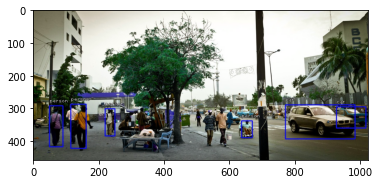

In [ ]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

#Import image
image = cv2.imread("/content/trainval/test_results/image_000000011.jpg")

#Show the image with matplotlib
plt.imshow(image)
plt.show()

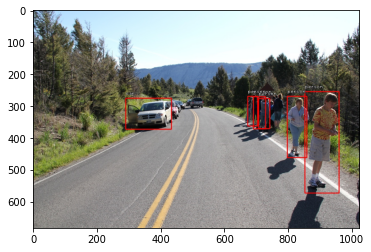

In [ ]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

#Import image
image = cv2.imread("/content/trainval/test_results/image_000000033.jpg")
im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
plt.imshow(im_rgb)
plt.show()

## Some False negatives

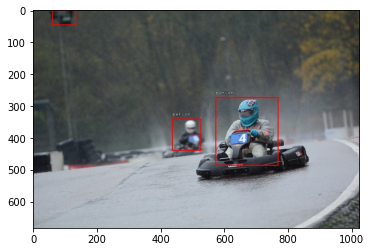

In [ ]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

#Import image
image = cv2.imread("/content/trainval/test_results/image_000000146.jpg")
im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
plt.imshow(im_rgb)
plt.show()

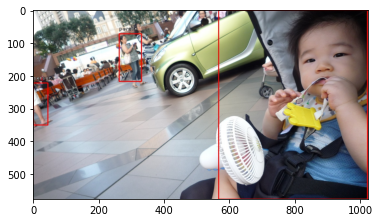

In [ ]:
%matplotlib inline

import cv2
from matplotlib import pyplot as plt

#Import image
image = cv2.imread("/content/trainval/test_results/image_000000452.jpg")
im_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#Show the image with matplotlib
plt.imshow(im_rgb)
plt.show()

## Recommendations
1. We can further improve the model by increasing the number of epochs, currently I have only ran for 10 Epochs.

2. We can also, upgrade the pretrained model from Resnet50 to Resnet101. As, the deeper the model more accurate will be the results but are slower and use more memory.

### Link for Trained Model - https://drive.google.com/file/d/1wlhzf2Ifj536SavtzR2HQ_XtnlTO544v/view?usp=sharing